# 1. Install dependencies

In [ ]:
!pip install -U langchain langchain-community langchain-huggingface sentence-transformers
!pip install git+https://github.com/openai/whisper.git
!pip install transformers PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.4.1
    Uninstalling sentence-transformers-3.4.1:
      Successfully uninstalled sentence-transformers-3.4.1
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-b35zxg4h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-b35zxg4h
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2. Import Libraries

In [ ]:
import os
import fitz  # PyMuPDF
from PIL import Image
import whisper

from google.colab import files
from transformers import BlipProcessor, BlipForConditionalGeneration

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document


# 3. PDF Upload + Embedding

In [ ]:
def upload_pdf():
    print("📂 Upload your PDF file.")
    uploaded = files.upload()
    return list(uploaded.keys())[0]

def extract_text(pdf_path):
    doc = fitz.open(pdf_path)
    return "\n".join([page.get_text("text") for page in doc])

def process_text(text):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_text(text)
    docs = [Document(page_content=c) for c in chunks]
    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.from_documents(docs, embedder)


# 4. Image Upload + Captioning + Embedding

In [ ]:
def upload_image():
    print("🖼️ Upload your image.")
    uploaded = files.upload()
    return list(uploaded.keys())[0]

def caption_image(image_path):
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    image = Image.open(image_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

def process_image_caption(caption):
    doc = Document(page_content=caption)
    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.from_documents([doc], embedder)


# 5. Audio Upload + Transcription + Embedding

In [ ]:
def upload_audio():
    print("🔊 Upload your audio file (MP3/WAV).")
    uploaded = files.upload()
    return list(uploaded.keys())[0]

def transcribe_audio(audio_path):
    model = whisper.load_model("base")
    result = model.transcribe(audio_path)
    return result["text"]

def process_audio_text(text):
    doc = Document(page_content=text)
    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.from_documents([doc], embedder)


# 6. Combine All Vector Stores

In [ ]:
def merge_vectorstores(*stores):
    merged = stores[0]
    for store in stores[1:]:
        merged.merge_from(store)
    return merged


# 7. Run the pipeline

In [ ]:
# 📂 PDF
pdf_path = upload_pdf()
pdf_text = extract_text(pdf_path)
pdf_vectorstore = process_text(pdf_text)

# 🖼️ Image
image_path = upload_image()
caption = caption_image(image_path)
print("📸 Caption:", caption)
image_vectorstore = process_image_caption(caption)

# 🔊 Audio
audio_path = upload_audio()
audio_text = transcribe_audio(audio_path)
print("🎧 Transcription:\n", audio_text)
audio_vectorstore = process_audio_text(audio_text)

# 🔗 Combine all
combined_vectorstore = merge_vectorstores(pdf_vectorstore, image_vectorstore, audio_vectorstore)
retriever = combined_vectorstore.as_retriever()


📂 Upload your PDF file.


Saving metals.pdf to metals (1).pdf
🖼️ Upload your image.


Saving download.jfif to download (1).jfif
📸 Caption: captain america the first avenge
🔊 Upload your audio file (MP3/WAV).


Saving Unstoppable-(Mr-Jat.in).mp3 to Unstoppable-(Mr-Jat.in) (2).mp3


100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 44.5MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🎧 Transcription:
  I'll smile, the north it takes to fool this town. I'll do it till the sun goes down. I'm knocked with a night time. Oh yeah, oh yeah, I'll tell you what you want to hear. My sunglasses on my light shed a tear. It's now a red light. Oh yeah, oh yeah, oh yeah. I'm moving my arms so you are so my end. I'm moving my arms so you that I, yeah, yeah, yeah. I'm knocked up a bottle. I'm a budget with no breaks. I'm invincible. And I will never sing the name. I'm so powerful. I don't need batteries today. I'm so confident. Yeah, I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. It's gone. Only alone I will cry. I'm now you'll never see what's hiding. And now I don't know deep down. Yeah, yeah, I know I've heard that that you're feeling shows. You're on the way to make friendship score. But I'm too afraid now. Yeah, yeah, yeah. I'm moving my arms so you are so my end. I'm moving my arms so you that I, yeah, yeah, 

📂 Upload PDF file


Saving metals.pdf to metals.pdf
🖼️ Upload image


Saving download.jfif to download.jfif


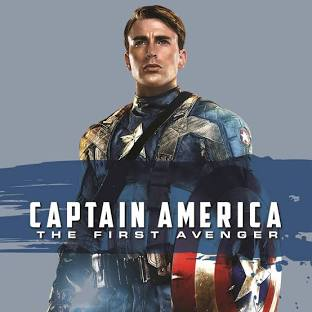

📝 Caption: captain america the first avenge
🔊 Upload audio


Saving Unstoppable-(Mr-Jat.in).mp3 to Unstoppable-(Mr-Jat.in).mp3


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🎧 Transcript:  I'll smile, the north it takes to fool this town. I'll do it till the sun goes down. I'm knocked with a night time. Oh yeah, oh yeah, I'll tell you what you want to hear. My sunglasses on my light shed a tear. It's now a red light. Oh yeah, oh yeah, oh yeah. I'm moving my arms so you are so my end. I'm moving my arms so you that I, yeah, yeah, yeah. I'm knocked up a bottle. I'm a budget with no breaks. I'm invincible. And I will never sing the name. I'm so powerful. I don't need batteries today. I'm so confident. Yeah, I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. I'm unstoppable today. It's gone. Only alone I will cry. I'm now you'll never see what's hiding. And now I don't know deep down. Yeah, yeah, I know I've heard that that you're feeling shows. You're on the way to make friendship score. But I'm too afraid now. Yeah, yeah, yeah. I'm moving my arms so you are so my end. I'm moving my arms so you that I, yeah, yeah, yeah

Text(value='Summarize the content from the uploaded PDF, image, and audio', description='🗣️ Query:', layout=La…

Output()

In [ ]:
# ✅ Setup
import os
import fitz  # PyMuPDF
from PIL import Image
import whisper
import IPython.display as display
from transformers import BlipProcessor, BlipForConditionalGeneration
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from google.colab import files
import ipywidgets as widgets
from IPython.display import display as ipydisplay

# 🔐 OpenRouter API
os.environ["OPENROUTER_API_KEY"] = "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"
os.environ["OPENAI_API_KEY"] = os.environ["OPENROUTER_API_KEY"]
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 🧠 Helper to process text into vectorstore
def make_vectorstore_from_text(text):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_text(text)
    docs = [Document(page_content=c) for c in chunks]
    return FAISS.from_documents(docs, embedder)

# 📄 PDF
def process_pdf():
    print("📂 Upload PDF file")
    uploaded = files.upload()
    pdf_path = list(uploaded.keys())[0]
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    return make_vectorstore_from_text(text)

# 🖼️ Image
def process_image():
    print("🖼️ Upload image")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
    image = Image.open(image_path).convert("RGB")
    display.display(image)

    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    print("📝 Caption:", caption)
    return make_vectorstore_from_text(caption)

# 🎧 Audio
def process_audio():
    print("🔊 Upload audio")
    uploaded = files.upload()
    audio_path = list(uploaded.keys())[0]
    model = whisper.load_model("base")
    result = model.transcribe(audio_path)
    print("🎧 Transcript:", result["text"])
    return make_vectorstore_from_text(result["text"])

# 🔗 Combine
def combine_all_sources():
    vs1 = process_pdf()
    vs2 = process_image()
    vs3 = process_audio()
    # Merge vs2 and vs3 into vs1
    vs1.merge_from(vs2) # Merge vs2 into vs1
    vs1.merge_from(vs3) # Merge vs3 into vs1
    return vs1 # Return the merged vs1

# 🚀 Build LLM QA Chain
def build_qa_chain(retriever):
    llm = ChatOpenAI(
        model="openai/gpt-3.5-turbo",
        openai_api_key=os.environ["OPENAI_API_KEY"],
        openai_api_base="https://openrouter.ai/api/v1"
    )
    return RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

# 💬 Interactive Input
def interactive_chat(qa_chain):
    input_box = widgets.Text(
        value='Summarize the content from the uploaded PDF, image, and audio',
        placeholder='Ask me anything...',
        description='🗣️ Query:',
        layout=widgets.Layout(width='80%')
    )
    output = widgets.Output()

    def on_enter(change):
        output.clear_output()
        query = change['new']
        with output:
            print("🤖 Thinking...")
            response = qa_chain.run(query)
            print("🧠 Response:\n", response)

    input_box.observe(on_enter, names='value')
    ipydisplay(input_box, output)

# 🧩 Run everything
retriever = combine_all_sources().as_retriever()
qa_chain = build_qa_chain(retriever)
interactive_chat(qa_chain)


📂 Upload PDF file


Saving metals.pdf to metals (1).pdf
🖼️ Upload image


Saving download.jfif to download (1).jfif


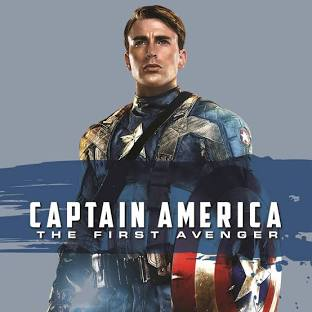

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

📝 Visual Analysis: Describe everything you see in the image captain america the first avenger

🔊 Upload audio


In [ ]:
# ✅ Setup
import os
import fitz  # PyMuPDF
from PIL import Image
import whisper
import IPython.display as ipd
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from google.colab import files
import ipywidgets as widgets
from IPython.display import display as ipydisplay

# 🔐 OpenRouter API setup
os.environ["OPENROUTER_API_KEY"] = "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"
os.environ["OPENAI_API_KEY"] = os.environ["OPENROUTER_API_KEY"]
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

# ⚙️ Embeddings
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 🧠 Vectorstore from text
def make_vectorstore_from_text(text):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_text(text)
    docs = [Document(page_content=c) for c in chunks]
    return FAISS.from_documents(docs, embedder)

# 📄 PDF
def process_pdf():
    print("📂 Upload PDF file")
    uploaded = files.upload()
    pdf_path = list(uploaded.keys())[0]
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    return make_vectorstore_from_text(text)

# 🖼️ Image using BLIP-2
def process_image():
    print("🖼️ Upload image")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
    image = Image.open(image_path).convert("RGB")
    ipydisplay(image)  # Fixed line

    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto")

    prompt = "Describe everything you see in the image"
    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

    out = model.generate(**inputs, max_new_tokens=100)
    caption = processor.decode(out[0], skip_special_tokens=True)

    print("📝 Visual Analysis:", caption)
    return make_vectorstore_from_text(caption)

# 🎧 Audio using Whisper
def process_audio():
    print("🔊 Upload audio")
    uploaded = files.upload()
    audio_path = list(uploaded.keys())[0]
    model = whisper.load_model("base")
    result = model.transcribe(audio_path)
    print("🎧 Transcript:", result["text"])
    return make_vectorstore_from_text(result["text"])

# 🔗 Combine all into one vectorstore
def combine_all_sources():
    vs1 = process_pdf()
    vs2 = process_image()
    vs3 = process_audio()
    vs1.merge_from(vs2)
    vs1.merge_from(vs3)
    return vs1

# 🚀 Build LLM QA Chain
def build_qa_chain(retriever):
    llm = ChatOpenAI(
        model="openai/gpt-3.5-turbo",
        openai_api_key=os.environ["OPENAI_API_KEY"],
        openai_api_base="https://openrouter.ai/api/v1"
    )
    return RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

# 💬 Chat Interface
def interactive_chat(qa_chain):
    input_box = widgets.Text(
        value='Summarize the content from the uploaded PDF, image, and audio',
        placeholder='Ask me anything...',
        description='🗣️ Query:',
        layout=widgets.Layout(width='80%')
    )
    output = widgets.Output()

    def on_enter(change):
        output.clear_output()
        query = change['new']
        with output:
            print("🤖 Thinking...")
            response = qa_chain.run(query)
            print("🧠 Response:\n", response)

    input_box.observe(on_enter, names='value')
    ipydisplay(input_box, output)

# 🧩 Main Execution
retriever = combine_all_sources().as_retriever()
qa_chain = build_qa_chain(retriever)
interactive_chat(qa_chain)
